Designed experiment :  
using sb3, we compare the results bewteen training while rewarding higher speeds, seeing whats the limit we can reach

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import highway_env
import numpy as np
import tensorboard
from stable_baselines3 import DQN

from configs.config_sb3 import config_dict as config_dict_sdb3


In [ ]:
high_speed_rewards = [0.4 + 0.1*i for i in range(10)]

for i in range(10):

    env = gym.make("highway-fast-v0")
    env.unwrapped.config["high_speed_reward"] = high_speed_rewards[i]

    model = DQN('MlpPolicy', env,
                policy_kwargs=dict(net_arch=[256, 256]),
                learning_rate=5e-4,
                buffer_size=15000,
                learning_starts=200,
                batch_size=32,
                gamma=0.8,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=50,
                verbose=1,
                tensorboard_log="highway_dqn_task_4/")
    model.learn(int(2e4))
    model.save(f"highway_dqn_task_4/model_{i}")


In [22]:
# Evaluation
import pandas as pd

n_episodes = 50

data = pd.DataFrame(columns=["high_speed_reward", "average_speed", "crash_rate", "avg_reward", "std_reward"])

for i in range(10):
    print(f"Evaluating model {i} with high speed reward {high_speed_rewards[i]}")
    # Load and test saved model
    model = DQN.load(f"highway_dqn_task_4/model_{i}")
    high_speed_reward = 0.4 + 0.1*i
    total_rewards = []
    total_speed_avgs = []
    crash_count = 0

    for episode in range(n_episodes):
        env = gym.make("highway-fast-v0")
        env.unwrapped.config["high_speed_reward"] = high_speed_reward
        obs, info = env.reset()
        total_reward = 0
        delta_speed = 0
        speed_data = []

        done = truncated = False
        obs, info = env.reset()
        while not (done or truncated):
            action, _states = model.predict(obs, deterministic=False)
            obs, reward, done, truncated, info = env.step(action)
            # logging speed changes
            if action == 3 :
                delta_speed += 1
            if action == 4 :
                delta_speed -= 1
            speed_data.append(delta_speed)
            # logging crash rates
            if info["crashed"]:
                crash_count += 1
            # logging rewards
            total_reward += reward
        
        total_rewards.append(total_reward)
        total_speed_avgs.append(np.mean(speed_data))
    
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    avg_speed = np.mean(total_speed_avgs)
    crash_rate = crash_count / n_episodes
    
    # add a line to the dataframe
    data = pd.concat([data, pd.DataFrame([[high_speed_reward, avg_speed, crash_rate, avg_reward, std_reward]], columns=["high_speed_reward", "average_speed", "crash_rate", "avg_reward", "std_reward"])])

                

Evaluating model 0 with high speed reward 0.4


C:\Users\tedma\AppData\Local\Temp\ipykernel_11960\4102423575.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([[high_speed_reward, avg_speed, crash_rate, avg_reward, std_reward]], columns=["high_speed_reward", "average_speed", "crash_rate", "avg_reward", "std_reward"])])


Evaluating model 1 with high speed reward 0.5
Evaluating model 2 with high speed reward 0.6000000000000001
Evaluating model 3 with high speed reward 0.7000000000000001
Evaluating model 4 with high speed reward 0.8
Evaluating model 5 with high speed reward 0.9
Evaluating model 6 with high speed reward 1.0
Evaluating model 7 with high speed reward 1.1
Evaluating model 8 with high speed reward 1.2000000000000002
Evaluating model 9 with high speed reward 1.3


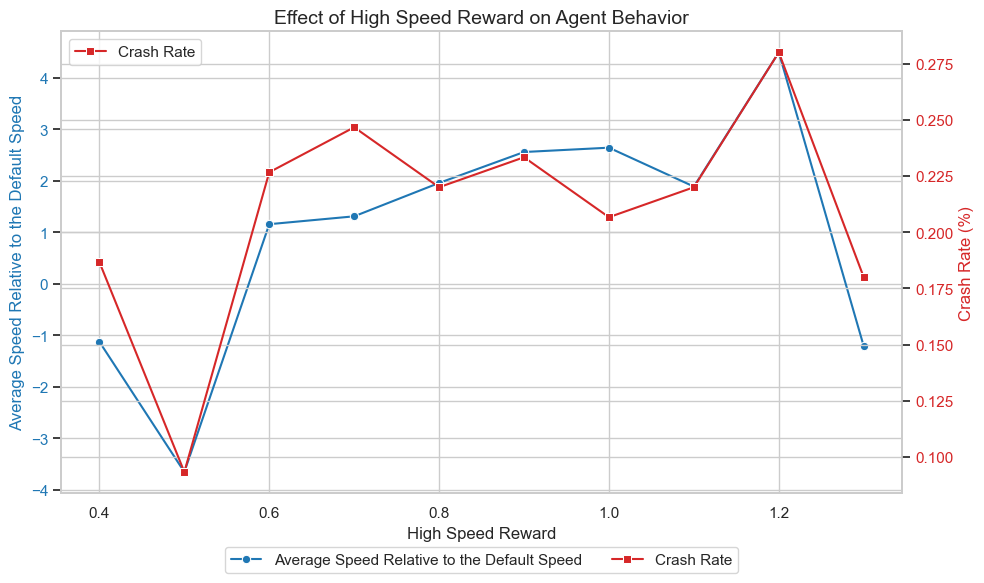

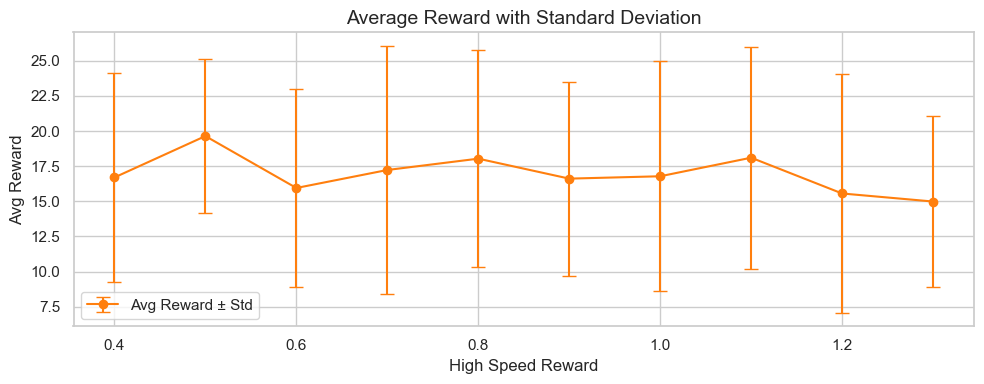

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average_speed on primary y-axis
line1 = sns.lineplot(
    data=data,
    x="high_speed_reward",
    y="average_speed",
    marker="o",
    label="Average Speed Relative to the Default Speed",
    ax=ax1,
    color="#1f77b4"
)

# Create a second y-axis for crash_rate
ax2 = ax1.twinx()
line2 = sns.lineplot(
    data=data,
    x="high_speed_reward",
    y="crash_rate",
    marker="s",
    label="Crash Rate",
    ax=ax2,
    color="#d62728"
)

# Label axes
ax1.set_xlabel("High Speed Reward", fontsize=12)
ax1.set_ylabel("Average Speed Relative to the Default Speed", color="#1f77b4", fontsize=12)
ax2.set_ylabel("Crash Rate (%)", color="#d62728", fontsize=12)

# Match tick colors to line colors
ax1.tick_params(axis='y', labelcolor="#1f77b4")
ax2.tick_params(axis='y', labelcolor="#d62728")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Add a title
plt.title("Effect of High Speed Reward on Agent Behavior", fontsize=14)

plt.tight_layout()
plt.show()


# Add reward ± std as a separate figure below
fig2, ax3 = plt.subplots(figsize=(10, 4))
ax3.errorbar(
    data["high_speed_reward"],
    data["avg_reward"],
    yerr=data["std_reward"],
    fmt='o-', capsize=5, color="#ff7f0e", label="Avg Reward ± Std"
)
ax3.set_xlabel("High Speed Reward", fontsize=12)
ax3.set_ylabel("Avg Reward", fontsize=12)
ax3.set_title("Average Reward with Standard Deviation", fontsize=14)
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()
